### Modelo Final Segmentación/Volumen -> MoE4

In [100]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
import unets_repo
from keras import backend as K
import cv2
import time
import nibabel as nib
import nibabel as nib
from nyul import nyul_apply_standard_scale

In [2]:
tf. __version__

'2.10.0'

In [3]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

batch_size = 1
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
vspe = n_val_img//batch_size

def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)
def batch_generator(suj_path, mask_path,batch_size):
    suj_files = os.listdir(suj_path)
    indices = np.arange(len(suj_files))
    indices = np.random.permutation(indices)
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch) == batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch = []

train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"),batch_size)
val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"),batch_size)

#### Métricas

> Se agrego el casteo a Double para el cálculo del Dice manual

In [170]:
def Dice(targets, inputs):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + K.epsilon()) / (K.sum(targets) + K.sum(inputs) + K.epsilon())

def Jaccard(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    
    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + K.epsilon())/(union + K.epsilon())

#### Modelos elegidos
    > Attention Unet w/SeLu
    > Unet 3+ w/ReLu
    > Small Unet w/ReLu (32 filters + ConvTranspose)
    > Classic Unet w/SeLu (64 filters + Upsampling/Conv2d)

Tomando las 9 redes mejores estudiadas: <br>
> Se buscó por cada red el mejor threshold tal que mejore su Dice <br>
 Se estudió cuales redes clasifican mejor el dataset de validación para máscaras con y sin próstata <br>
 Se seleccionó las 4 mejores considerando también una diversificación en sus caracteristicas (attention, red densa, small, upsampling) <br>

Luego se buscó el mejor threshold para el MoE <br>

En conclusión se construyó un Mixture of Experts con threshold estático (so far) de 4 modelos.

In [ ]:
#coeff =   [95, 123, 52, 131, 64, 76, 66, 89, 112] #cuantas fueron el mejor dice de las imagenes con prostata
#coeff_n = [559, 512, 554, 553, 556, 532, 537, 544, 545] # +1 si dijieron q es full background y era.
#indices = [0.95, 0.45, 0.7, 0.65, 0.85, 0.95, 0.95, 0.95, 0.75]

In [4]:
attunetselu = unets_repo.AttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
attunetselu.load_weights("modelsh5/0.8160_attunet_selu_lecun_aug_dicebce.h5")
unet3 = unets_repo.unet3plus(input_size=(256,256,1))
unet3.load_weights("modelsh5/0.5662_unet3plus_relu_aug_dicebce.h5")
sunet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=32)
sunet.load_weights("modelsh5/0.7947_unet_small_relu_he_aug.h5")
classicunet = unets_repo.classicUNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
classicunet.load_weights("modelsh5/0.8233_classicunet_selu_lecun_aug_dicebce.h5")

In [ ]:
#attunetselu.save("modelsh5/attunet_final.h5")
#unet3.save("modelsh5/unet3_final.h5")
#sunet.save("modelsh5/sunet_final.h5")
#classicunet.save("modelsh5/classicunet_final.h5")

ths moe
* 0.1 0.8054671080480669
* 0.2 0.8054671080480669
* 0.3 0.8553433531107572
* 0.4 0.8603819215897122
* 0.5 0.8583272483360339
* 0.6 0.8536344124264371
* 0.7 0.8485078012767154
* 0.8 0.8279149816562783
* 0.9 0.8279149816562783

<function matplotlib.pyplot.show(close=None, block=None)>

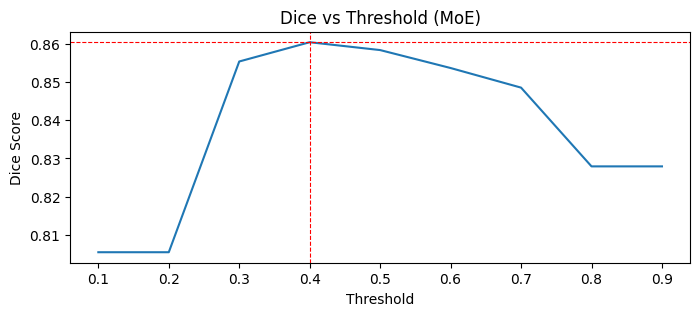

In [54]:
dices = [0.805467108048066,0.8054671080480669,0.8553433531107572,0.8603819215897122,0.8583272483360339,0.8536344124264371,0.8485078012767154,0.8279149816562783,0.8279149816562783]
ths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(8,3))
plt.plot(ths,dices)
plt.xlabel("Threshold")
plt.ylabel("Dice Score")
#plt.grid(axis='x', linestyle='--', alpha=0.7, which='both')
plt.axvline(x=0.4, color='red', linestyle='--', linewidth=0.8)
plt.axhline(y=0.8603819215897122, color='red', linestyle='--', linewidth=0.8)
plt.title("Dice vs Threshold (MoE)")
plt.show

In [5]:
netnames = ["AttUnet w/s","Unet3+","sUnet","ClassicUnet"]
nets = [attunetselu,unet3,sunet,classicunet]
thresholds = [0.95,0.45,0.65,0.95] # th talque hard dice score es máx en set de validación
coeff = [169, 201, 228, 161] # cantidad de imágenes CON prostata donde obtuvieron mejor hard dice score
moe_th = 0.4 # th talque hard dice score es máx en set de validación

#### Hard Dice Score para el MoE sobre el set de validación: 0.86

In [34]:
for moe_th in range(1,10):
    moe_th/=10
    dice = 0
    for _ in range(n_val_img):
        test_image_batch, test_mask_batch = val_gen_ds.__next__()
        test_img = test_image_batch[0]
        ground_truth = test_mask_batch[0]
        test_img_norm = test_img[:,:]
        test_img_input = np.expand_dims(test_img_norm, 0)
        prediction = np.zeros(shape=(1,256,256,256))
        for i,net in enumerate(nets):
            prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff) #se pondera según su performance en imágenes con próstata.
        predicted_img_th = (prediction[0,:,:,0] > moe_th)*1
        dice += Dice(ground_truth,predicted_img_th).numpy()
    print(moe_th, dice/n_val_img)

0.1 0.8054671080480669
0.2 0.8054671080480669
0.3 0.8553433531107572
0.4 0.8603819215897122
0.5 0.8583272483360339
0.6 0.8536344124264371
0.7 0.8485078012767154
0.8 0.8279149816562783
0.9 0.8279149816562783


Cálculo de promedio (sobre set de validacion 1228 imágenes) de tiempo de inferencia (en segundos) para MoE (considerando el paso de thresholding del heatmap final)

In [ ]:
suma= 0 
for _ in range(n_val_img):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = np.zeros(shape=(1,256,256,256))
    start = time.time()
    for i,net in enumerate(nets):
        prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff) #se pondera según su performance en imágenes con próstata.
    predicted_img_th = (prediction[0,:,:,0] > moe_th)*1
    end = time.time()
    suma += (end-start)


In [11]:
print("Promedio tiempo de inferencia: ",suma/n_val_img)

Promedio tiempo de inferencia:  0.2861164307361317


---
### Estudio de resultados en TEST!!

Las imágenes de test ya están preprocesadas desde cuando se armó el dataset

Hard Dice Score en TEST = 0.842!!

In [6]:
fp3 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data"
test_gen_ds = batch_generator(os.path.join(fp3,"sujetos"),os.path.join(fp3,"mascaras"),batch_size)
batch_size = 1
n_val_img = len(os.listdir(os.path.join(fp3,"sujetos")))
vspe = n_val_img//batch_size

In [8]:
dice = 0
for _ in range(n_val_img):
    test_image_batch, test_mask_batch = test_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = np.zeros(shape=(1,256,256,256))
    for i,net in enumerate(nets):
        prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff) #se pondera según su performance en imágenes con próstata.
    predicted_img_th = (prediction[0,:,:,0] > moe_th)*1
    dice += Dice((ground_truth>=0.5).astype(np.uint8),predicted_img_th).numpy()
print(dice/n_val_img)

0.8420735427604445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tiempo de inferencia:  0.552851676940918
Hausdorff Distance: 18.0


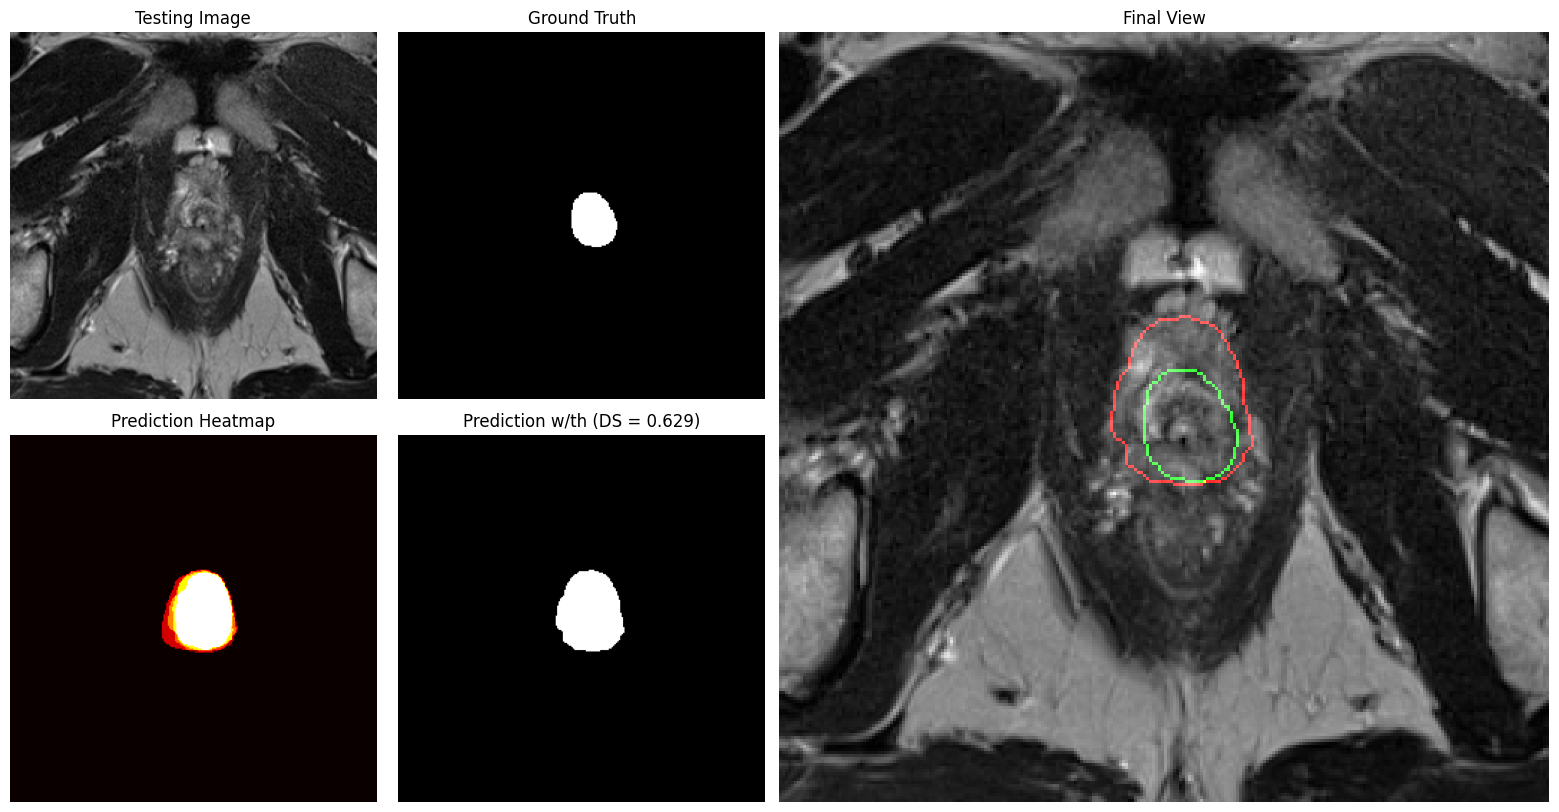

In [216]:
#test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_image_batch, test_mask_batch = test_gen_ds.__next__()
test_img = test_image_batch[0]
ground_truth = test_mask_batch[0]
test_img_norm = test_img[:, :]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = np.zeros(shape=(1, 256, 256, 256))

start = time.time()
for i, net in enumerate(nets):
    prediction += ((net(test_img_input).numpy()) > thresholds[i]) * coeff[i] / sum(coeff)

predicted_img_th = (prediction[0, :, :, 0] > moe_th) * 1
end = time.time()
print("Tiempo de inferencia: ", end-start)
dice = Dice(ground_truth, predicted_img_th).numpy()

contours, _ = cv2.findContours(predicted_img_th.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoursg, _ = cv2.findContours((ground_truth>=0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bordes = np.zeros_like(predicted_img_th, dtype=np.uint8)
for contour in contours:
    bordes = cv2.drawContours(bordes, [contour], 0, (255, 0, 0), 1)
bordesg = np.zeros_like(ground_truth, dtype=np.uint8)
for contour in contoursg:
    bordesg = cv2.drawContours(bordesg, [contour], 0, (255, 0, 0), 1)
    
bordes2 = cv2.cvtColor(bordes.astype(np.uint8), cv2.COLOR_GRAY2RGB)
bordes2[bordes == 255] = [255, 0, 0]
bordes3 = cv2.cvtColor(bordesg.astype(np.uint8), cv2.COLOR_GRAY2RGB)
bordes3[bordesg == 255] = [0, 255, 0]
reshaped_arr = test_img.reshape((256, 256, 1))
rgb_arr = np.repeat(reshaped_arr, 3, axis=2)
n = Normalize()(rgb_arr)

contour1 = np.column_stack(np.where(bordes != 0))
contour2 = np.column_stack(np.where(bordesg != 0))


distance = hausdorff_distance(contour1, contour2)
print(f'Hausdorff Distance: {distance}')

plt.figure(figsize=(20, 10))

# First 4 subplots on the left in a 2x2 grid
plt.subplot2grid((2, 4), (0, 0))
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.axis("off")

plt.subplot2grid((2, 4), (0, 1))
plt.title('Ground Truth')
plt.imshow((ground_truth>=0.5).astype(np.uint8), cmap='gray')
plt.axis("off")

plt.subplot2grid((2, 4), (1, 0))
plt.title('Prediction Heatmap')
plt.imshow(prediction[0, :, :, 0],cmap='hot')
plt.axis("off")

plt.subplot2grid((2, 4), (1, 1))
plt.title(f'Prediction w/th (DS = {round(dice, 3)})')
plt.imshow(predicted_img_th, cmap='gray')
plt.axis("off")

# Final view as a bigger plot filling 2 rows and 2 columns
plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
plt.title(f'Final View')
plt.imshow(n + bordes2 + bordes3, cmap='gray')
plt.axis("off")

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.01, hspace=0.1)

plt.show()


Hausdorff Distance: 10.0


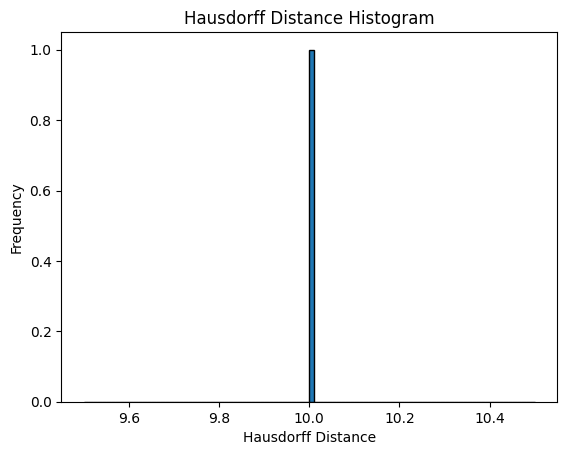

In [198]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt

def hausdorff_distance(contour1, contour2):
    """
    Calculate the Hausdorff distance between two sets of contours.
    """
    distance1 = directed_hausdorff(contour1, contour2)[0]
    distance2 = directed_hausdorff(contour2, contour1)[0]
    return max(distance1, distance2)

def plot_histogram(distances, bins=100):
    """
    Plot a histogram of the Hausdorff distances.
    """
    plt.hist(distances, bins=bins, edgecolor='black')
    plt.title('Hausdorff Distance Histogram')
    plt.xlabel('Hausdorff Distance')
    plt.ylabel('Frequency')
    plt.show()


contour1 = np.column_stack(np.where(bordes != 0))
contour2 = np.column_stack(np.where(bordesg != 0))


distance = hausdorff_distance(contour1, contour2)
print(f'Hausdorff Distance: {distance}')


distances = [hausdorff_distance(contour1, contour2) for contour2 in [contour2]]  # Replace [contour2] with other contours
plot_histogram(distances)


---
#### Estudio de resultados y comparativa con método elipsoide

Para calcular el volumen por el método del elipsoide necesitaría al menos 2 vistas de alta resolución. <br>
Por eso se opta por aproximarlo usando 1 vista (axial) * cantidad de slices con prostata. <br>
En teoría esto sería "mejor" incluso que algo manual de un médico. Suponiendo que las máscaras están bien hechas. <br>

#### Diseño de Pipeline para el cálculo de volumen de una secuencia

A partir de leer 1 secuencia en formato nifti, la función devuelve su volumen (en pixeles o ml)<br>
> Las secuencias ya tienen el n4bias correction

In [163]:
fp = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data"

n_val_img = len(os.listdir(os.path.join(fp,"sujetos")))
vspe = n_val_img//batch_size

secuencias = []
segmentaciones = []
for file in sorted(os.listdir(fp)):
    if "sujeto_" in file:
        secuencias.append(os.path.join(fp,file))
    elif "segmentacion" in file:
        segmentaciones.append(os.path.join(fp,file))

In [103]:
standard_path = 'nyul_landmarks.npy'
media = 3.54715519304951 #del conjunto de train
var = 42.85355462071623 #del conjunto de train

Predicción:

In [80]:
v1 = []
for path in secuencias:
#path = secuencias[0] # cual secuencia nifti quiero estudiar

    volumen = 0 # volumen a medir

    x = nib.load(path)
    y = x.get_fdata()
    y = nyul_apply_standard_scale(y, standard_path)     #1 aplico Nyul
    for slices in range(np.size(y,2)):
        img = y[63:319,63:319,slices]                   #2 Recorto 256x256
        img = (img-media)/var                           #3 z-score normalization                              
        
        ###---------------ESTO HAY QUE CONVERTILO EN FUNCION------------------------------
        test_img_input = np.expand_dims(img, 0)
        prediction = np.zeros(shape=(1,256,256,256))
        for i,net in enumerate(nets):
            prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff)
        predicted_img_th = (prediction[0,:,:,0] > moe_th)*1
        ### -----------------------------------------------------------------------------------
        volumen += np.sum(predicted_img_th)*(x.header["pixdim"][1]*x.header["pixdim"][2]*x.header["pixdim"][3])         #4 sumo volumen = N*px*d1*d2*d3
    print(f"Volumen de próstata = {round(volumen/1000,1)} cm3")             #12s por secuencia y mm3 = 0.001 cm3
    v1.append(round(volumen/1000,1))

Volumen de próstata = 102.6 cm3
Volumen de próstata = 40.6 cm3
Volumen de próstata = 30.8 cm3
Volumen de próstata = 36.2 cm3
Volumen de próstata = 94.0 cm3
Volumen de próstata = 49.8 cm3
Volumen de próstata = 32.3 cm3
Volumen de próstata = 29.1 cm3
Volumen de próstata = 51.2 cm3
Volumen de próstata = 96.5 cm3
Volumen de próstata = 71.9 cm3
Volumen de próstata = 78.1 cm3


Segmentación Manual:

In [79]:
v2 = []
for path in segmentaciones:
    #path = segmentaciones[5] # cual secuencia nifti quiero estudiar

    volumen = 0 # volumen a medir

    x = nib.load(path)
    y = x.get_fdata()
    for slices in range(np.size(y,2)):
        img = y[63:319,63:319,slices]                   #1 Recorto 256x256                           
        volumen += np.sum(img)*(x.header["pixdim"][1]*x.header["pixdim"][2]*x.header["pixdim"][3])         #2 sumo volumen = N*px*d1*d2*d3
    print(f"Volumen de próstata = {round(volumen/1000,1)} cm3")             #0.5s por secuencia y mm3 = 0.001 cm3
    v2.append(round(volumen/1000,1))

Volumen de próstata = 139.1 cm3
Volumen de próstata = 43.8 cm3
Volumen de próstata = 33.5 cm3
Volumen de próstata = 32.4 cm3
Volumen de próstata = 118.4 cm3
Volumen de próstata = 50.6 cm3
Volumen de próstata = 39.0 cm3
Volumen de próstata = 30.7 cm3
Volumen de próstata = 49.0 cm3
Volumen de próstata = 94.1 cm3
Volumen de próstata = 65.6 cm3
Volumen de próstata = 65.6 cm3


In [92]:
error = []
for i,v in enumerate(v2):
    error.append(abs((v1[i]*100/v)-100))
print(np.mean(error),np.std(error))
    

11.134442309235803 7.572962828648361


Método elipsoide:

In [112]:
path = segmentaciones[11] # cual secuencia nifti quiero estudiar

volumen = 0 # volumen a medir
mask_true = []

x = nib.load(path)
y = x.get_fdata()
for slices in range(np.size(y,2)):
    img = y[63:319,63:319,slices]                   #1 Recorto 256x256                           
    volumen += np.sum(img)*(x.header["pixdim"][1]*x.header["pixdim"][2]*x.header["pixdim"][3])         #2 sumo volumen = N*px*d1*d2*d3
    if np.any(img): mask_true.append(1) 
    else: mask_true.append(0)
print(f"Volumen de próstata = {round(volumen/1000,1)} cm3")             #0.5s por secuencia y mm3 = 0.001 cm3
print("eje largo = ",round(np.sum(mask_true)*x.header["pixdim"][3],2))

Volumen de próstata = 65.6 cm3
eje largo =  57.6


Lista de estudio manual (axis automáticos medseg -> exagera/busca los mas representativos no son reales):
2 ejes marcados automaticamente por medseg + 1 eje calculado con la fun de arriba. Todo hecho con las máscaras y no a mano. (suponiendo una técnica semiautomática o algo así porq las segmentaciones reales no las tendrías.)

0 -> 81.2 * 73.1 * 61.4 * 0.52 / 1000 = 189.51<br>
1 -> 44.8 * 69.8 * 52.6 * 0.52 / 1000 = 85.53<br>
2 -> 33 * 52.4 * 33.2 * 0.52 / 1000 =  29.85<br>
3 -> 31.9 * 49.9 * 33 * 0.52 / 1000 =  27.31<br>
4 -> 66.4 * 49.9 * 64 * 0.52 / 1000 = 110.26<br>
5 -> 58.2 * 35.1 * 50.4 * 0.52 / 1000 = 53.53<br>
6 -> 55.6 * 48.8 * 35 * 0.52 / 1000 = 49.38<br>
7 -> 51 * 39.6 * 28.75 * 0.52 / 1000 = 30.19<br>
8 -> 53.3 * 42 * 43.2 * 0.52 / 1000 = 50.28<br>
9 -> 65.3 * 52.9 * 57.6 * 0.52 / 1000 = 103.46<br>
10 -> 52.9 * 46.3 * 57.6 * 0.52 / 1000 = 73.36<br>
11 -> 60.9 * 53.1 * 57.6 * 0.52 / 1000 = 96.85<br>

Lista de estudio manual (axis manual SLICER -> depende de mi capacidad(no médica) de diferenciar la próstata):
3 ejes marcados a mano, 2 sobre axial y una sobre la reconstruccion sagital de slicer. Ejes corregidos con la reconstrucción coronal y sagital, hecho con ganas.

0 -> 61.04 * 47.36 * 70.3 * 0.52 / 1000 = 105.67<br>
1 ->  51.02 * 30.21 * 47.91 * 0.52 / 1000 = 38.4<br>
2 ->  51.22 * 26.22 * 45.15 * 0.52 / 1000 =  31.53<br>
3 ->  29.79 * 49.18 * 44.23 * 0.52 / 1000 =  33.69<br>
4 ->  64.21 * 44.56 * 69 * 0.52 / 1000 = 102.66<br>
5 ->  33.43 * 55.58 * 51.69 * 0.52 / 1000 = 49.94<br>
6 ->  38.18 * 57.28 * 45.71 * 0.52 / 1000 = 51.98<br>
7 ->  39.52 * 38.9 * 48.29 * 0.52 / 1000 = 38.6<br>
8 ->  48.5 * 53.6 * 36.36 * 0.52 / 1000 = 49.15<br>
9 ->  61.65 * 47.03 * 58 * 0.52 / 1000 = 87.44<br>
10 -> 49.92 * 41.32 * 54.46 * 0.52 / 1000 = 58.41<br>
11 -> 45.3 * 54.42 * 57.79 * 0.52 / 1000 = 74.08<br>


In [7]:
vol_manual = [105.67,38.4,31.53,33.69,102.66,49.94,51.98,38.6,49.15,87.44,58.41,74.05]
vol_moe = [102.6,40.6,30.8,36.2,94.0,49.8,32.3,29.1,51.2,96.5,71.9,78.1]
vol_truth = [139.1,43.8,33.5,32.4,118.4,50.6,39.0,30.7,49.0,94.1,65.6,65.6] 

Análisis de Bland-Altman

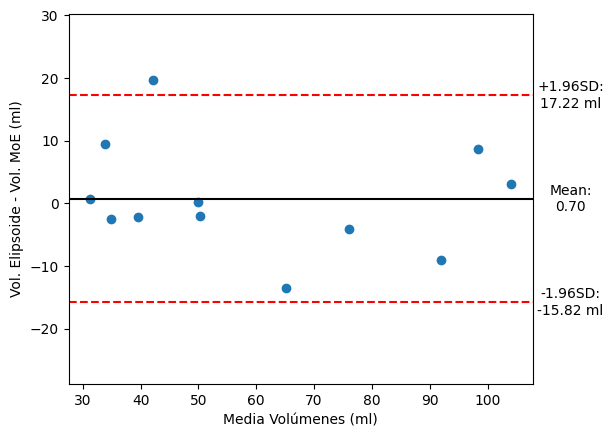

In [33]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md, color='black', linestyle='-')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    return md, sd, mean, CI_low, CI_high
md, sd, mean, CI_low, CI_high = bland_altman_plot(vol_manual, vol_moe)
plt.xlabel("Media Volúmenes (ml)")
plt.ylabel("Vol. Elipsoide - Vol. MoE (ml)")
plt.ylim(md - 3.5*sd, md + 3.5*sd)

xOutPlot = np.min(mean) + (np.max(mean) - np.min(mean)) * 1.14

plt.text(xOutPlot, md - 1.96*sd, r'-1.96SD:' + "\n" + "%.2f" % CI_low + " ml", ha="center", va="center")
plt.text(xOutPlot, md + 1.96*sd, r'+1.96SD:' + "\n" + "%.2f" % CI_high + " ml", ha="center", va="center")
plt.text(xOutPlot, md, r'Mean:' + "\n" + "%.2f" % md, ha="center", va="center")

plt.subplots_adjust(right=0.85)
plt.show()




In [80]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd

    plt.scatter(mean, diff, *args, **kwargs)

    # Create a horizontal gradient background between the dashed lines
    extent = [np.min(mean)-5, np.max(mean)+5, md - 1.96*sd, md + 1.96*sd]
    
    # Define a custom colormap with a single color (e.g., 'coolwarm' colormap with only the blue color)
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['red', 'white', 'red'])

    gradient = np.linspace(0, 1, 256).reshape(-1, 1)
    gradient_color = custom_cmap(gradient)
    
    plt.imshow(gradient_color, aspect='auto', extent=extent, alpha=0.15)

    plt.axhline(md, color='black', linestyle='-')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.axhline(md + sd, color='gray', linestyle='--')
    plt.axhline(md - sd, color='gray', linestyle='--')
    return md, sd, mean, CI_low, CI_high

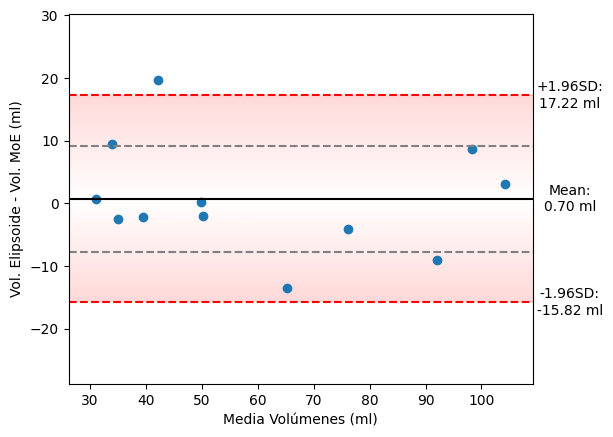

In [82]:
md, sd, mean, CI_low, CI_high = bland_altman_plot(vol_manual, vol_moe)
plt.xlabel("Media Volúmenes (ml)")
plt.ylabel("Vol. Elipsoide - Vol. MoE (ml)")
plt.ylim(md - 3.5*sd, md + 3.5*sd)

plt.xlim(np.min(mean)-5,np.max(mean)+5)

xOutPlot = np.min(mean) + (np.max(mean) - np.min(mean)) * 1.16

plt.text(xOutPlot, md - 1.96*sd, r'-1.96SD:' + "\n" + "%.2f" % CI_low + " ml", ha="center", va="center")
plt.text(xOutPlot, md + 1.96*sd, r'+1.96SD:' + "\n" + "%.2f" % CI_high + " ml", ha="center", va="center")
plt.text(xOutPlot, md, r'Mean:' + "\n" + "%.2f" % md + " ml", ha="center", va="center")

plt.subplots_adjust(right=0.85)
plt.show()

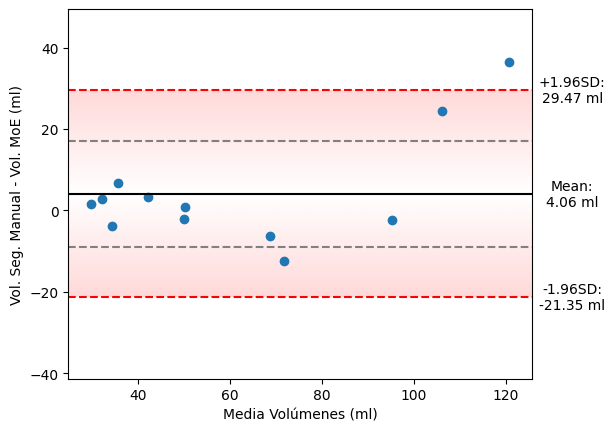

In [83]:
md, sd, mean, CI_low, CI_high = bland_altman_plot(vol_truth, vol_moe)
plt.xlabel("Media Volúmenes (ml)")
plt.ylabel("Vol. Seg. Manual - Vol. MoE (ml)")
plt.ylim(md - 3.5*sd, md + 3.5*sd)
plt.xlim(np.min(mean)-5,np.max(mean)+5)

xOutPlot = np.min(mean) + (np.max(mean) - np.min(mean)) * 1.15

plt.text(xOutPlot, md - 1.96*sd, r'-1.96SD:' + "\n" + "%.2f" % CI_low + " ml", ha="center", va="center")
plt.text(xOutPlot, md + 1.96*sd, r'+1.96SD:' + "\n" + "%.2f" % CI_high + " ml", ha="center", va="center")
plt.text(xOutPlot, md, r'Mean:' + "\n" + "%.2f" % md + " ml", ha="center", va="center")

plt.subplots_adjust(right=0.85)
plt.show()

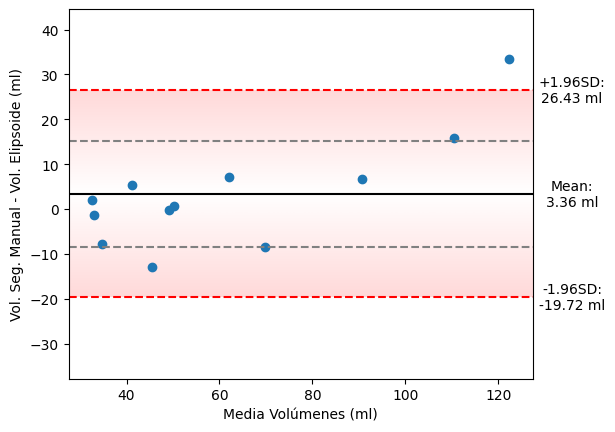

In [81]:
md, sd, mean, CI_low, CI_high = bland_altman_plot(vol_truth, vol_manual)
plt.xlabel("Media Volúmenes (ml)")
plt.ylabel("Vol. Seg. Manual - Vol. Elipsoide (ml)")
plt.ylim(md - 3.5*sd, md + 3.5*sd)
plt.xlim(np.min(mean)-5,np.max(mean)+5)

xOutPlot = np.min(mean) + (np.max(mean) - np.min(mean)) * 1.15

plt.text(xOutPlot, md - 1.96*sd, r'-1.96SD:' + "\n" + "%.2f" % CI_low + " ml", ha="center", va="center")
plt.text(xOutPlot, md + 1.96*sd, r'+1.96SD:' + "\n" + "%.2f" % CI_high + " ml", ha="center", va="center")
plt.text(xOutPlot, md, r'Mean:' + "\n" + "%.2f" % md + " ml", ha="center", va="center")

plt.subplots_adjust(right=0.85)
plt.show()

In [84]:
import math

def pearson_correlation(x, y):
    n = len(x)
    x_sum = sum(x)
    y_sum = sum(y)
    xy_sum = sum([x[i]*y[i] for i in range(n)])
    x_squared_sum = sum([x[i]**2 for i in range(n)])
    y_squared_sum = sum([y[i]**2 for i in range(n)])
    numerator = n*xy_sum - x_sum*y_sum
    denominator = math.sqrt((n*x_squared_sum - x_sum**2) * (n*y_squared_sum - y_sum**2))
    return numerator/denominator

In [85]:
pearson_correlation(vol_manual, vol_moe)

0.9483329199099599

In [86]:
pearson_correlation(vol_truth, vol_manual)

0.9666041940765792

In [87]:
pearson_correlation(vol_truth, vol_moe)

0.9389506958597529

Graf en val set:


In [106]:
fp = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

secuencias = []
segmentaciones = []
for file in sorted(os.listdir(fp)):
    if "sujeto_" in file:
        secuencias.append(os.path.join(fp,file))
    elif "segmentacion" in file:
        segmentaciones.append(os.path.join(fp,file))

In [149]:
v1 = []
for path in secuencias:
    volumen = 0 # volumen a medir
    x = nib.load(path)
    y = x.get_fdata()
    y = nyul_apply_standard_scale(y, standard_path)     #1 aplico Nyul
    for slices in range(np.size(y,2)):
        img = y[63:319,63:319,slices]                   #2 Recorto 256x256
        img = (img-media)/var                           #3 z-score normalization                              
        
        ###---------------ESTO HAY QUE CONVERTILO EN FUNCION------------------------------
        test_img_input = np.expand_dims(img, 0)
        prediction = np.zeros(shape=(1,256,256,256))
        for i,net in enumerate(nets):
            prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff)
        predicted_img_th = (prediction[0,:,:,0] > moe_th)*1
        ### -----------------------------------------------------------------------------------
        volumen += np.sum(predicted_img_th)*(x.header["pixdim"][1]*x.header["pixdim"][2]*x.header["pixdim"][3])         #4 sumo volumen = N*px*d1*d2*d3
    #print(f"Volumen de próstata = {round(volumen/1000,1)} cm3")             #12s por secuencia y mm3 = 0.001 cm3
    v1.append(round(volumen/1000,1))

v2 = []
for path in segmentaciones:
    volumen = 0 # volumen a medir
    x = nib.load(path)
    y = x.get_fdata()
    for slices in range(np.size(y,2)):
        img = y[63:319,63:319,slices]                   #1 Recorto 256x256                           
        volumen += np.sum(img)*(x.header["pixdim"][1]*x.header["pixdim"][2]*x.header["pixdim"][3])         #2 sumo volumen = N*px*d1*d2*d3
    #print(f"Volumen de próstata = {round(volumen/1000,1)} cm3")             #0.5s por secuencia y mm3 = 0.001 cm3
    v2.append(round(volumen/1000,1))

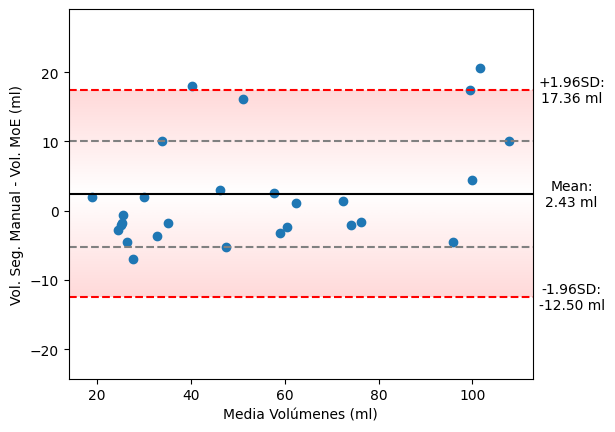

In [111]:
md, sd, mean, CI_low, CI_high = bland_altman_plot(v2, v1)
plt.xlabel("Media Volúmenes (ml)")
plt.ylabel("Vol. Seg. Manual - Vol. MoE (ml)")
plt.ylim(md - 3.5*sd, md + 3.5*sd)
plt.xlim(np.min(mean)-5,np.max(mean)+5)

xOutPlot = np.min(mean) + (np.max(mean) - np.min(mean)) * 1.15

plt.text(xOutPlot, md - 1.96*sd, r'-1.96SD:' + "\n" + "%.2f" % CI_low + " ml", ha="center", va="center")
plt.text(xOutPlot, md + 1.96*sd, r'+1.96SD:' + "\n" + "%.2f" % CI_high + " ml", ha="center", va="center")
plt.text(xOutPlot, md, r'Mean:' + "\n" + "%.2f" % md + " ml", ha="center", va="center")

plt.subplots_adjust(right=0.85)
plt.show()

In [161]:
from skimage.measure import label, regionprops
from scipy.spatial.distance import directed_hausdorff

# Calculate the Hausdorff distance between two binary images
def hausdorff_distance(y_true, y_pred):
    # Extract the connected components from the images
    true_labels = label(y_true)
    pred_labels = label(y_pred)

    # Convert the images to sets of points
    true_points = [region.coords for region in regionprops(true_labels)]
    pred_points = [region.coords for region in regionprops(pred_labels)]

    # Calculate the directed Hausdorff distance between the sets of points
    distance = directed_hausdorff(true_points, pred_points)[0]

    return distance

In [199]:
haus = []
for _ in range(n_val_img):
    test_image_batch, test_mask_batch = test_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = np.zeros(shape=(1,256,256,256))
    for i,net in enumerate(nets):
        prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff) 
    predicted_img_th = (prediction[0,:,:,0] > moe_th)*1
    contours, _ = cv2.findContours(predicted_img_th.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bg = np.zeros(shape=(256,256))
    bordes = cv2.drawContours(bg, contours, -1, (255, 255, 255), 2)
    contours2, _ = cv2.findContours((ground_truth>=0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bg2 = np.zeros(shape=(256,256))
    bordes2 = cv2.drawContours(bg2, contours2, -1, (255, 255, 255), 2)
    
    contour1 = np.column_stack(np.where(bordes != 0))
    contour2 = np.column_stack(np.where(bordesg != 0))
    haus.append(hausdorff_distance(contour1, contour2))
    
print(haus)

[85.90692637965812, 99.29753269845128, inf, 66.49060083951716, 93.98404119849285, inf, inf, 23.769728648009426, inf, inf, 17.72004514666935, 50.59644256269407, 44.91102314577124, inf, 102.77159140540736, 45.5411901469428, 53.150729063673246, inf, inf, inf, inf, 29.0, 97.74456506629922, 74.0, inf, 95.85927185202274, 18.681541692269406, 58.412327466040935, 87.36131867136622, 62.5859409132754, inf, 34.0, inf, inf, 67.26812023536856, 63.071388124885914, inf, 56.462376853972415, 51.97114584074513, 48.373546489791295, inf, inf, inf, inf, inf, inf, 56.089214649520635, 39.11521443121589, inf, 27.018512172212592, 47.0, 59.77457653551382, 96.13532129243653, inf, inf, 33.1058907144937, 12.083045973594572, 100.66280345788111, 101.83319694480774, 102.95630140987001, inf, inf, inf, inf, inf, 40.049968789001575, 45.0, 46.0, 51.10772935672255, 123.36936410632909, 41.14608122288197, 96.317184344228, 64.13267497929586, 92.65527507918802, inf, inf, inf, 58.215118311311535, inf, 47.67598976424087, 80.2309

In [202]:
haus_nonzero = [value for value in haus if value!=np.inf]

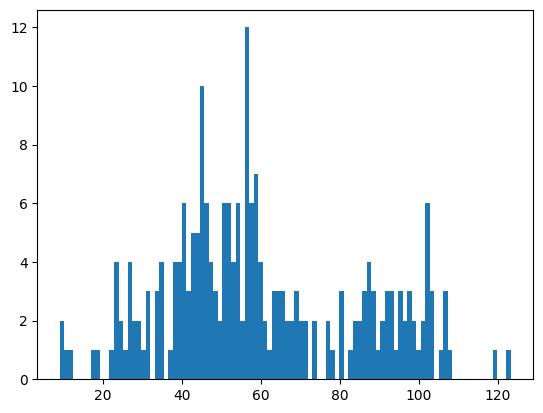

In [204]:
plt.hist(haus_nonzero,bins=100)
plt.show()

In [37]:
print(np.mean(haus_nonzero),np.mean(haus))


1242.7505436935382 702.9700045135165


In [88]:
from sklearn.linear_model import LinearRegression

def deming_regression(x, y):
    X = np.array(x)[:, np.newaxis]
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    return slope, intercept

Slope: 0.8966097446258583
Intercept: 6.845632592275038


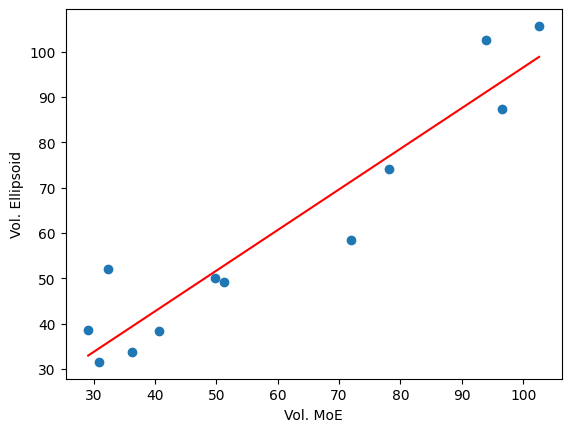

In [89]:
slope, intercept = deming_regression(vol_moe, vol_manual)
print("Slope:", slope)
print("Intercept:", intercept)
x_fit = np.linspace(min(vol_moe), max(vol_moe))
y_fit = x_fit * slope + intercept

plt.scatter(vol_moe, vol_manual)
plt.plot(x_fit, y_fit, 'r')
plt.xlabel('Vol. MoE')
plt.ylabel('Vol. Ellipsoid')
plt.show()

Slope: 1.206603771635114
Intercept: -8.219095796083288


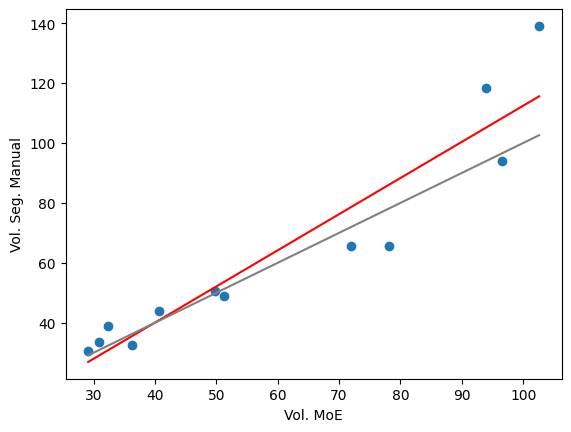

In [53]:
slope, intercept = deming_regression(vol_moe, vol_truth)
print("Slope:", slope)
print("Intercept:", intercept)
x_fit = np.linspace(min(vol_moe), max(vol_moe))
y_fit = x_fit * slope + intercept

plt.scatter(vol_moe, vol_truth)
plt.plot(x_fit, y_fit, 'r')
plt.plot(x_fit,x_fit,"gray")
plt.xlabel('Vol. MoE')
plt.ylabel('Vol. Seg. Manual')
plt.show()

In [91]:
def passing_bablok(method1, method2):
    """Perform Passing-Bablok analysis."""
    #
    # Calculate the gradients of the lines between each pair of points
    #
    n_points = len(method1)
    # sv is a list of the gradients between of each pair of points
    sv = []
    # k is the number of gradients less than -1
    k = 0
    for i in range(n_points - 1):
        for j in range(i + 1, n_points):
            dy = method2[j] - method2[i]
            dx = method1[j] - method1[i]
            # Ignore gradients that are vertical (ie the x values of the points
            # are the same)
            if dx != 0:
                gradient = dy / dx
            elif dy < 0:
                gradient = -1.e+23
            elif dy > 0:
                gradient = 1.e+23
            else:
                gradient = None
            if gradient is not None:
                sv.append(gradient)
                k += (gradient < -1)
    # Sort the gradients into ascending order
    sv.sort()

    #
    # Find the estimated gradient and confidence limits
    #
    m0 = (len(sv) - 1) / 2
    if m0 == int(m0):
        # If odd
        gradient_est = sv[k + int(m0)]
    else:
        # If even
        gradient_est = 0.5 * (sv[k + int(m0 - 0.5)] + sv[k + int(m0 + 0.5)])
    # Calculate the index of the upper and lower confidence bounds
    w = 1.96
    ci = w * math.sqrt((n_points * (n_points - 1) * (2 * n_points + 5)) / 18)
    n_gradients = len(sv)
    m1 = int(round((n_gradients - ci) / 2))
    m2 = n_gradients - m1 - 1
    # Calculate the lower and upper bounds of the gradient
    (gradient_lb, gradient_ub) = (sv[k + m1], sv[k + m2])

    def calc_intercept(method1, method2, gradient):
        """Calculate intercept given points and a gradient."""
        temp = []
        for i in range(len(method1)):
            temp.append(method2[i] - gradient * method1[i])
        return np.median(temp)

    # Calculate the intercept as the median of all the intercepts of all the
    # lines connecting each pair of points
    int_est = calc_intercept(method1, method2, gradient_est)
    int_ub = calc_intercept(method1, method2, gradient_lb)
    int_lb = calc_intercept(method1, method2, gradient_ub)

    return (gradient_est, gradient_lb, gradient_ub), (int_est, int_lb, int_ub)

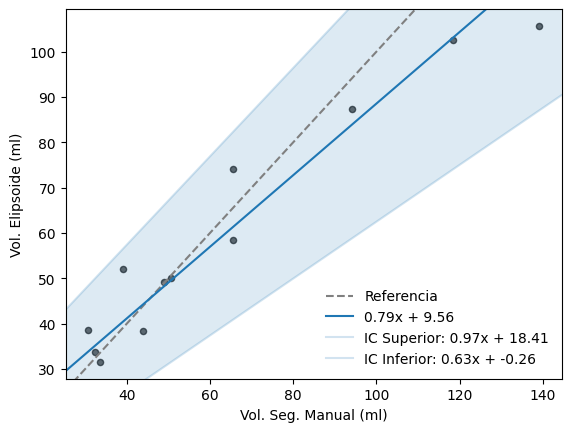

In [146]:
beta, alpha = passing_bablok(vol_truth, vol_manual)

#
# Plot
#
ax = plt.axes()
ax.set(
    xlabel='Vol. Seg. Manual (ml)',
    ylabel='Vol. Elipsoide (ml)'

)
# Scatter plot
ax.scatter(vol_truth, vol_manual, c='k', s=20, alpha=0.6, marker='o')
# Get axis limits
left, right = plt.xlim()
top, bottom = plt.ylim()
# Keep current axis limits
ax.set_xlim(left, right)
ax.set_ylim(top, bottom)
# Reference line
ax.plot(
    [left, right], [left, right], c='grey', ls='--', label='Referencia'
)
# Passing-Bablok regression line
x = np.array([left, right])
y = beta[0] * x + alpha[0]
ax.plot(x, y, label=f'{beta[0]:4.2f}x + {alpha[0]:4.2f}')
# Passing-Bablok regression line - confidence intervals
x = np.array([left, right])
y_lb = beta[1] * x + alpha[1]
y_ub = beta[2] * x + alpha[2]
ax.plot(
    x, y_ub, c='tab:blue', alpha=0.2,
    label=f'IC Superior: {beta[2]:4.2f}x + {alpha[2]:4.2f}'
)
ax.plot(
    x, y_lb, c='tab:blue', alpha=0.2,
    label=f'IC Inferior: {beta[1]:4.2f}x + {alpha[1]:4.2f}'
)
ax.fill_between(x, y_ub, y_lb, alpha=0.15)
# Legend
ax.legend(frameon=False)
# Show
plt.show()

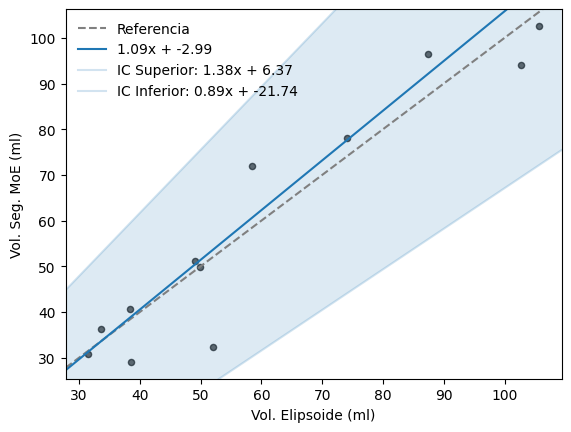

In [143]:
beta, alpha = passing_bablok(vol_manual, vol_moe)

#
# Plot
#
ax = plt.axes()
ax.set(
    xlabel='Vol. Elipsoide (ml)',
    ylabel='Vol. Seg. MoE (ml)'
)
# Scatter plot
ax.scatter(vol_manual, vol_moe, c='k', s=20, alpha=0.6, marker='o')
# Get axis limits
left, right = plt.xlim()
top, bottom = plt.ylim()
# Keep current axis limits
ax.set_xlim(left, right)
ax.set_ylim(top, bottom)
# Reference line
ax.plot(
    [left, right], [left, right], c='grey', ls='--', label='Referencia'
)
# Passing-Bablok regression line
x = np.array([left, right])
y = beta[0] * x + alpha[0]
ax.plot(x, y, label=f'{beta[0]:4.2f}x + {alpha[0]:4.2f}')
# Passing-Bablok regression line - confidence intervals
x = np.array([left, right])
y_lb = beta[1] * x + alpha[1]
y_ub = beta[2] * x + alpha[2]
ax.plot(
    x, y_ub, c='tab:blue', alpha=0.2,
    label=f'IC Superior: {beta[2]:4.2f}x + {alpha[2]:4.2f}'
)
ax.plot(
    x, y_lb, c='tab:blue', alpha=0.2,
    label=f'IC Inferior: {beta[1]:4.2f}x + {alpha[1]:4.2f}'
)
ax.fill_between(x, y_ub, y_lb, alpha=0.15)
# Legend
ax.legend(frameon=False)
# Show
plt.show()

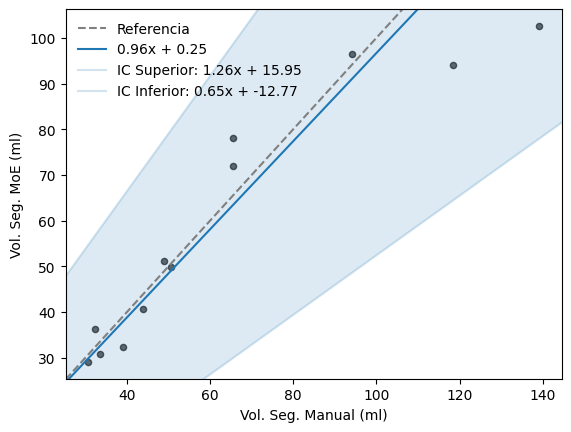

In [137]:
beta, alpha = passing_bablok(vol_truth, vol_moe)

#
# Plot
#
ax = plt.axes()
ax.set(
    xlabel='Vol. Seg. Manual (ml)',
    ylabel='Vol. Seg. MoE (ml)'
)
# Scatter plot
ax.scatter(vol_truth, vol_moe, c='k', s=20, alpha=0.6, marker='o')
# Get axis limits
left, right = plt.xlim()
top, bottom = plt.ylim()
# Keep current axis limits
ax.set_xlim(left, right)
ax.set_ylim(top, bottom)
# Reference line
ax.plot(
    [left, right], [left, right], c='grey', ls='--', label='Referencia'
)
# Passing-Bablok regression line
x = np.array([left, right])
y = beta[0] * x + alpha[0]
ax.plot(x, y, label=f'{beta[0]:4.2f}x + {alpha[0]:4.2f}')
# Passing-Bablok regression line - confidence intervals
x = np.array([left, right])
y_lb = beta[1] * x + alpha[1]
y_ub = beta[2] * x + alpha[2]
ax.plot(
    x, y_ub, c='tab:blue', alpha=0.2,
    label=f'IC Superior: {beta[2]:4.2f}x + {alpha[2]:4.2f}'
)
ax.plot(
    x, y_lb, c='tab:blue', alpha=0.2,
    label=f'IC Inferior: {beta[1]:4.2f}x + {alpha[1]:4.2f}'
)
ax.fill_between(x, y_ub, y_lb, alpha=0.15)
# Legend
ax.legend(frameon=False)
# Show
plt.show()

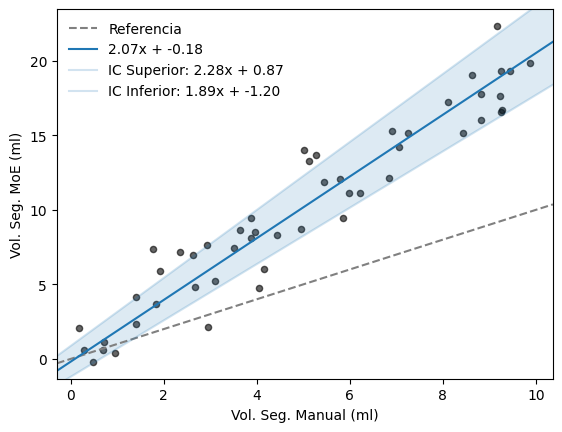

In [140]:
beta, alpha = passing_bablok(v1, v2)

#
# Plot
#
ax = plt.axes()
ax.set(
    xlabel='Vol. Seg. Manual (ml)',
    ylabel='Vol. Seg. MoE (ml)'
)
# Scatter plot
ax.scatter(v1, v2, c='k', s=20, alpha=0.6, marker='o')
# Get axis limits
left, right = plt.xlim()
top, bottom = plt.ylim()
# Keep current axis limits
ax.set_xlim(left, right)
ax.set_ylim(top, bottom)
# Reference line
ax.plot(
    [left, right], [left, right], c='grey', ls='--', label='Referencia'
)
# Passing-Bablok regression line
x = np.array([left, right])
y = beta[0] * x + alpha[0]
ax.plot(x, y, label=f'{beta[0]:4.2f}x + {alpha[0]:4.2f}')
# Passing-Bablok regression line - confidence intervals
x = np.array([left, right])
y_lb = beta[1] * x + alpha[1]
y_ub = beta[2] * x + alpha[2]
ax.plot(
    x, y_ub, c='tab:blue', alpha=0.2,
    label=f'IC Superior: {beta[2]:4.2f}x + {alpha[2]:4.2f}'
)
ax.plot(
    x, y_lb, c='tab:blue', alpha=0.2,
    label=f'IC Inferior: {beta[1]:4.2f}x + {alpha[1]:4.2f}'
)
ax.fill_between(x, y_ub, y_lb, alpha=0.15)
# Legend
ax.legend(frameon=False)
# Show
plt.show()

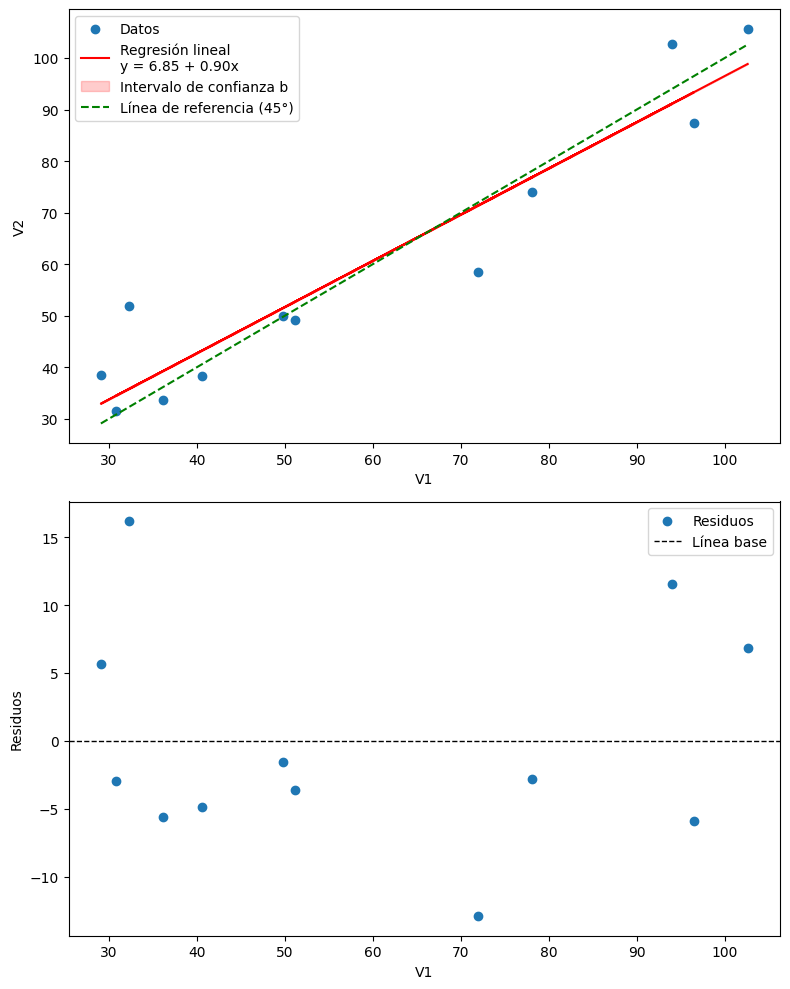

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def passing_bablok_analysis(v1, v2):
    v1  = np.asarray(v1)
    v2 = np.asarray(v2)
    # Calcula la regresión lineal entre v1 y v2
    slope, intercept, _, _, _ = linregress(v1, v2)

    # Calcula los residuos
    residuals = v2 - (intercept + slope * v1)

    # Calcula los intervalos de confianza para a y b
    a_ci = np.percentile(residuals, [2.5, 97.5])
    b_ci = np.percentile(slope, [2.5, 97.5])

    # Crea la figura y los subgráficos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

    # Gráfico de dispersión con intervalo de confianza para b
    ax1.scatter(v1, v2, label='Datos')
    ax1.plot(v1, intercept + slope * v1, color='red', label=f'Regresión lineal\ny = {intercept:.2f} + {slope:.2f}x')
    ax1.fill_between(v1, (intercept + b_ci[0] * v1), (intercept + b_ci[1] * v1), color='red', alpha=0.2, label='Intervalo de confianza b')
    
    # Línea de referencia con 45 grados
    reference_line = np.linspace(min(v1), max(v1), 100)
    ax1.plot(reference_line, reference_line, linestyle='--', color='green', label='Línea de referencia (45°)')
    
    ax1.legend()
    ax1.set_xlabel('V1')
    ax1.set_ylabel('V2')

    # Gráfico de residuos con intervalo de confianza para a
    ax2.scatter(v1, residuals, label='Residuos')
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, label='Línea base')
    #ax2.fill_between(v1, a_ci[0], a_ci[1], color='red', alpha=0.2, label='Intervalo de confianza a')
    ax2.legend()
    ax2.set_xlabel('V1')
    ax2.set_ylabel('Residuos')

    plt.tight_layout()
    plt.show()

passing_bablok_analysis(vol_moe, vol_manual)
